# Set Up

### Install Libraries

pip install -r reqiurements.txt

In [1]:
import requests
import sqlite3
from datetime import datetime, date, timedelta
from time import mktime, sleep
from stable_baselines3 import PPO
import gym
from gym import spaces
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker

# Get Data

### Create local database and tables

> bitcoin_data

- 비트코인 데이터를 저장할 테이블
- Columns
    - timestamp
    - price
    - volume

> validation

- 시뮬레이션 결과를 데이터를 저장할 테이블
- Columns
    - step
    - price
    - volume
    - balance
    - reward

In [2]:
conn = sqlite3.connect('./bitcoin_data.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS bitcoin_data (
    timestamp INTEGER PRIMARY KEY,
    price REAL,
    volume REAL
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS validation (
    step INTEGER PRIMARY KEY,
    action REAL,
    price REAL,
    volume REAL,
    balance REAL,
    reward REAL
)
''')

### Fetch Data

> API

- EndPoint : https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range
- Params
    - vs_currency
    - krw
    - from
    - to

> Remark

- 최대 1분에 5번까지 요청가능하므로, 하루치 데이터를 가져올 때 마다 12초간 쉬었다가 다시 데이터를 적재
- 최대 1년전 데이터까지 조회 가능

In [3]:
vs_currency = 'krw'             # 원화표시
ids = 'bitcoin'                 # 비트코인
start_date = date(2024, 3, 1)   # 크롤링 시작일자 (최대 1년전)
end_date = date(2025, 2, 1)     # 오늘날짜 (크롤링 종료일자)

In [ ]:
current_date = start_date
while current_date < end_date:
    try:
        # 하루치씩 비트코인 가격 크롤링
        timestamp_start = int(mktime(current_date.timetuple()))
        timestamp_end = timestamp_start + 86400 - 1

        response = requests.get('https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range',
                                params={'vs_currency': vs_currency, 'ids': ids, 'from': timestamp_start, 'to': timestamp_end})

        # status code가 200(정상)이 아닌 경우 다음날짜 크롤링
        if response.status_code != 200:
            print(f'\rError: {response.status_code} - {response.text}', end='')
            continue

        data = response.json()

        # 데이터 형식이 이상한 경우 다음날짜 크롤링
        if not 'prices' in data or not 'total_volumes' in data:
            print(f'\r price & volume not given', end='')
            continue
        
        print(f"\rFetching data for {current_date}", end="")
        for price_data, volume_data in zip(data['prices'], data['total_volumes']):
            timestamp = price_data[0]
            price = price_data[1]
            volume = volume_data[1]
            
            # 데이터베이스에 시간/가격/거래량 정보 추가
            cursor.execute('''
                INSERT OR REPLACE INTO bitcoin_data (timestamp, price, volume)
                VALUES (?, ?, ?)
                ''', (timestamp, price, volume))
        
        conn.commit()
        
        sleep(12)  # 분당 5번만 요청 가능하므로 한번 요청시마다 12초 쉼
    except:
        sleep(12)
    finally:
        current_date += timedelta(days=1)

# Environemnt

In [3]:
class CoinEnv(gym.Env):
    metadata = {'render.modes': ['human']}  # 사람이 이해하기 쉬운 방식으로 출력

    def __init__(self, data, seed:int, fee:float = 0.001, threshold:float = 0.5):
        """
        params
        - data : [(price, volume)]
        - seed : 초기자금
        - fee : 수수료 비율
        - threshold : action이 일어날 threshold
        """
        super(CoinEnv, self).__init__()
        assert len(data)>0 and seed>0
        self.data = data                   # (가격, 거래량) 시계열 데이터
        self._shares_held = 0              # 보유 코인수
        self.current_step = 0
        self._seed = seed
        self._balance = self._seed
        self.n_step = len(self.data)
        self._fee = fee
        self._threshold = threshold
        """
        observation_space : 관찰공간
        - price : 가격
        - volume : 거래량
        - balance : 잔고
        - reward : 보상 (= 잔고 + 보유코인가치 - 시드)
        """
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(4,), dtype=np.float32)    
        """
        action_space : 행동공간
        - 현재 잔고액의 몇 %를 매수금액으로 사용할 것인지(음수면 매도)
        """
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

    def reset(self):
        """ 상태공간을 초기화하는 함수 """
        self._balance = self._seed
        self._shares_held = 0
        self.current_step = 0
        (price, volume) = self.data[self.current_step]
        return np.array([price, volume, self._shares_held, self._balance], dtype=np.float32)

    def step(self, action):
        """ 
        잔고액의 action만큼 매수(음수면 매도)하는 경우, 다음 스텝의 상태공간을 반환하는 함수
        - 코인 구입수는 소수점 밑으로 가능하다 가정 (비트코인 1개에 1억이 넘어서 이게 현실적임)
        - 최대 매도 가능 코인수는 현재 보유 코인수로 가정 (공매도는 못한다고 가정)
        - 거래 수수료는 없다고 가정
        - 효용함수는 이익금액과 양의 선형관계 가정
        """
        current_price, _ = self.data[self.current_step]

        max_possible_buy = self._balance / current_price        # 최대 구입 가능 코인수
        max_possible_sell = self._shares_held 
        action_scaled = action[0] * max(max_possible_buy, max_possible_sell)
        if abs(action[0]) < self._threshold:   # 보유시
            next_balance = self._balance
            next_shares_held = self._shares_held
        elif action_scaled > 0:                 # 매수시
            shares_to_buy = min(action_scaled, max_possible_buy)
            next_balance = self._balance - shares_to_buy * current_price * (1+self._fee)
            next_shares_held = self._shares_held + shares_to_buy
        elif action_scaled < 0:                 # 매도시
            shares_to_sell = min(-action_scaled, max_possible_sell)
            next_balance = self._balance + shares_to_sell * current_price * (1-self._fee)
            next_shares_held = self._shares_held - shares_to_sell

        next_step = min(self.current_step + 1, self.n_step - 1)
        next_price, next_volume = self.data[next_step]
        next_state = np.array([next_price, next_volume, next_shares_held, next_balance], dtype=np.float32)
        reward = next_balance + next_shares_held * next_price - self._seed
        done = self.current_step >= self.n_step - 1

        # 상태 업데이트
        self.current_step = next_step
        self._balance = next_balance
        self._shares_held = next_shares_held        

        # 다음 상태, 보상, 완료여부, 추가정보
        return next_state, reward, done, {}

    @property
    def reward(self) -> float:
        # 보상 = 잔고 + 코인가격 x 보유코인수 - 시드
        price, _ = self.data[self.current_step]
        return self._balance + self._shares_held * price - self._seed

    def __repr__(self):
        current_price, _ = self.data[self.current_step]
        return f"Step:{self.current_step}|가격:{current_price}|잔고액:{self._balance}|보유코인수:{self._shares_held}"

### Train

훈련데이터 기간 : 2024-02-01~2024-11-30

In [4]:
dt = datetime(2025,1,1)
ts = int(dt.timestamp())*1000
cursor.execute('SELECT price, volume FROM bitcoin_data WHERE timestamp < ? order by timestamp', (ts,))
train_data = cursor.fetchall()
print(f'{len(train_data)}개의 시계열 데이터를 훈련데이터 사용')

7340개의 시계열 데이터를 훈련데이터 사용


In [5]:
seed = 1000000      # 초기자금 백만원
n_epochs = 1000     # 천번 훈련
fee = 0.001
threshold = 0.5

In [6]:
train_env = CoinEnv(train_data, seed, fee=fee, threshold=threshold) # 훈련환경 구성
model = PPO("MlpPolicy", env=train_env, n_epochs = n_epochs)        # PPO모델 불러오기
model.learn(total_timesteps=train_env.n_step)                       # 모델 학습
model.save('./model')                                               # 모델 저장

/Users/nsm/Desktop/N/비트코인/.venv/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


# Validation

검증데이터 기간 : 2024-12-01~2024-12-31

In [7]:
validation_start_ts = int(datetime(2025,1,1).timestamp())*1000

cursor.execute('SELECT price, volume FROM bitcoin_data WHERE timestamp > ? order by timestamp', \
    (validation_start_ts, ))
validation_data = cursor.fetchall()
print(f'{len(validation_data)}개의 시계열 데이터를 검증데이터 사용')

742개의 시계열 데이터를 검증데이터 사용


In [8]:
cursor.execute('delete from validation where 1=1')

validation_env = CoinEnv(validation_data, seed=seed)
obs = validation_env.reset()
for i in range(validation_env.n_step-1):
    action, _ = model.predict(obs)
    obs, reward, done, _ = validation_env.step(action)
    price, volume, _, balance = obs
    cursor.execute('''
        INSERT INTO validation (step, action, price, volume, balance, reward)
        VALUES (?, ?, ?, ?, ?, ?)
        ''', (validation_env.current_step, float(action[0]), float(price), float(volume), float(balance), float(reward)))
    if done:break
conn.commit()

# Plotting

In [9]:
cursor.execute('SELECT step, price, reward, action FROM validation')
data = cursor.fetchall()

x = [i[0] for i in data]
price = [float(i[1]) for i in data]
reward = [i[2] for i in data]
action = [(0 if abs(a)<threshold else a) for a in [float(i[-1]) for i in data]]

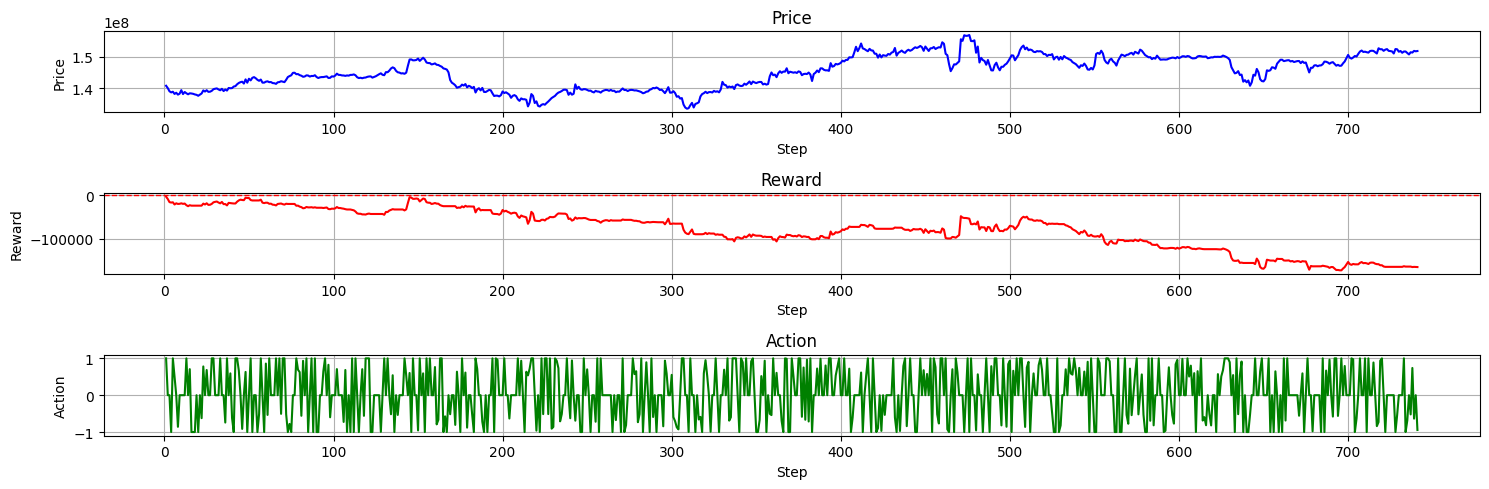

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(15, 5))

# 첫 번째 그래프: price
axes[0].plot(x, price, label='Price', color='b')
axes[0].set_title('Price')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Price')
axes[0].grid(True)

# 두 번째 그래프: reward
axes[1].plot(x, reward, label='Reward', color='r')
axes[1].set_title('Reward')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Reward')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].grid(True)

# 세 번째 그래프: action
axes[2].plot(x, action, label='Action', color='g')
axes[2].set_title('Action')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Action')
axes[2].grid(True)

plt.tight_layout()
plt.show()

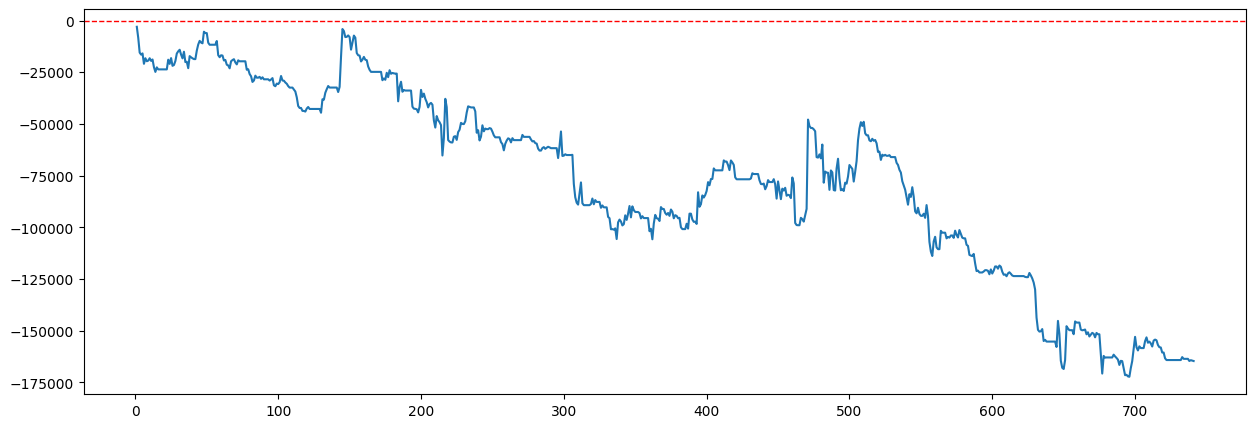

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, reward)
ax.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()